# Global Coffee Health Dataset - Sleep Quality Classification using SVM (RBF kernel)

## Loading dataset
https://www.kaggle.com/datasets/ahmeduzaki/earthquake-alert-prediction-dataset

In [47]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf

In [58]:
df = pd.read_csv("earthquake_alert_balanced_dataset.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1300, 6)


,magnitude,depth,cdi,mmi,sig,alert
0,7.0,14.0,8.0,7.0,0.0,green
1,6.9,25.0,4.0,4.0,-33.0,green
2,7.0,579.0,3.0,3.0,-13.0,green
3,7.3,37.0,5.0,5.0,65.0,green
4,6.6,624.0,0.0,2.0,-98.0,green


## Preparing training data

Cleanup the dataset

In [59]:
df = df.dropna().reset_index(drop=True)

In [64]:
features = ['magnitude', 'depth', 'cdi', 'mmi', 'sig']

Encode Categorical Features

In [60]:
# Encode target if categorical
target = 'alert'
if df[target].dtype == 'object':
    target_encoder = LabelEncoder()
    target_encoder.fit(df[target])
    target_encoder.classes_ = np.array(['green', 'yellow', 'orange', 'red'])
    df[target] = target_encoder.transform(df[target])
else:
    target_encoder = None

In [61]:
target_encoder.classes_

array(['green', 'yellow', 'orange', 'red'], dtype='<U6')

In [62]:
df.head()

,magnitude,depth,cdi,mmi,sig,alert
0,7.0,14.0,8.0,7.0,0.0,0
1,6.9,25.0,4.0,4.0,-33.0,0
2,7.0,579.0,3.0,3.0,-13.0,0
3,7.3,37.0,5.0,5.0,65.0,0
4,6.6,624.0,0.0,2.0,-98.0,0


Prepare train & validation sets

In [65]:
X = df[features].values
y = df[target].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True, stratify=y)

# Standardize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

y_train = tf.keras.utils.to_categorical(y_train)
y_val = tf.keras.utils.to_categorical(y_val)

In [66]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1170, 5), (130, 5), (1170, 4), (130, 4))

In [67]:
np.bincount(np.argmax(y_train, axis=1))

array([292, 293, 292, 293], dtype=int64)

# Randon forest classifier

In [68]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced')
rf.fit(X_train, np.argmax(y_train, axis=1))
print(rf.score(X_val, np.argmax(y_val, axis=1)))


0.9384615384615385


In [69]:
import pandas as pd
import numpy as np

importances = rf.feature_importances_
idx = np.argsort(importances)[::-1]

for i in idx[:15]:
    print(f"{features[i]}: {importances[i]:.4f}")

sig: 0.2498
mmi: 0.2314
depth: 0.1921
magnitude: 0.1723
cdi: 0.1543


# XGBoost classifier

In [70]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, scale_pos_weight=1, subsample=0.8, colsample_bytree=0.8)
xgb.fit(X_train, np.argmax(y_train, axis=1))
print(xgb.score(X_val, np.argmax(y_val, axis=1)))

c:\Users\Stefan\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [10:38:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


0.9307692307692308


# Preparing the NN model

In [73]:
def create_model(input_dim, output_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_dim=input_dim),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(output_dim, activation='softmax')
    ])
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall']) 
    return model

model = create_model(X_train.shape[1], y_train.shape[1])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 128)               768       
                                                                 
 batch_normalization_5 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 batch_normalization_6 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_27 (Dense)            (None, 4)                 516       
                                                                 
Total params: 18820 (73.52 KB)
Trainable params: 18308

# Training the model

In [74]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_data=(X_val, y_val), 
                    #class_weight=class_weights,
                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
                    )

Epoch 1/100
37/37 [==============================] - 4s 24ms/step - loss: 1.3450 - accuracy: 0.3957 - precision: 0.4484 - recall: 0.2487 - val_loss: 1.3006 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
37/37 [==============================] - 0s 7ms/step - loss: 1.0108 - accuracy: 0.5615 - precision: 0.6605 - recall: 0.3991 - val_loss: 1.2705 - val_accuracy: 0.4077 - val_precision: 1.0000 - val_recall: 0.0154
Epoch 3/100
37/37 [==============================] - 0s 8ms/step - loss: 0.8629 - accuracy: 0.6342 - precision: 0.7339 - recall: 0.4786 - val_loss: 1.2422 - val_accuracy: 0.3846 - val_precision: 0.7273 - val_recall: 0.1846
Epoch 4/100
37/37 [==============================] - 0s 7ms/step - loss: 0.7714 - accuracy: 0.6949 - precision: 0.7740 - recall: 0.5590 - val_loss: 1.2008 - val_accuracy: 0.4077 - val_precision: 0.6029 - val_recall: 0.3154
Epoch 5/100
37/37 [==============================] - 0s 7ms/step - loss: 0.7471 - accuracy: 0.7103 

# Evaluate the model

5/5 [==============================] - 0s 3ms/step

--- Evaluation Metrics ---
Accuracy : 0.9000
Precision: 0.9113
Recall   : 0.9000
F1-score : 0.8986

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.76      0.86        33
           1       0.82      1.00      0.90        32
           2       0.94      0.88      0.91        33
           3       0.89      0.97      0.93        32

    accuracy                           0.90       130
   macro avg       0.91      0.90      0.90       130
weighted avg       0.91      0.90      0.90       130


Confusion Matrix:
[[25  6  1  1]
 [ 0 32  0  0]
 [ 0  1 29  3]
 [ 0  0  1 31]]


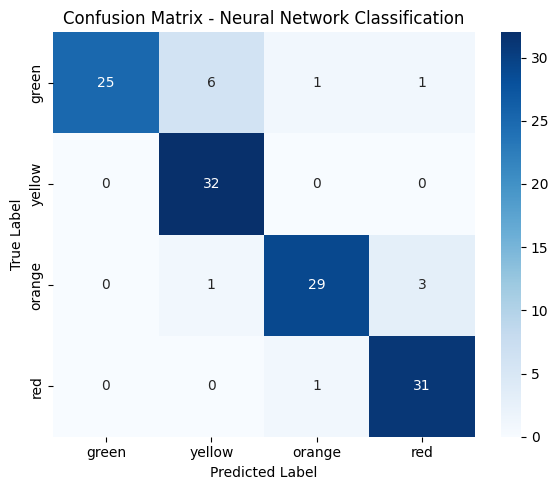

In [75]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Make predictions ---
y_pred_prob = model.predict(X_val)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_val, axis=1)

# --- Compute metrics ---
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec  = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1   = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n--- Evaluation Metrics ---")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))

# --- Determine labels ---
if target_encoder is not None:
    labels = target_encoder.classes_
else:
    labels = np.unique(y_true)

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix - Neural Network Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()
